In [2]:
pip install split-folders

In [3]:
import kagglehub
import os
import splitfolders
import math
import tensorflow as tf, numpy as np
from collections import Counter
from tensorflow.keras.applications.efficientnet import preprocess_input
from pathlib import Path
from collections import Counter
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from tensorflow.keras.layers import Layer, Conv2D, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Activation, Multiply, Concatenate, Input, Lambda, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import layers as L, Model
from tensorflow.keras.optimizers import Adam


In [4]:
# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'trashnet' dataset.
Path to dataset files: /kaggle/input/trashnet


In [5]:
sub_path = os.path.join(path, "dataset-resized")
subfolders = [f for f in os.listdir(sub_path) if os.path.isdir(os.path.join(sub_path, f))]
print(subfolders)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [6]:
base_path = os.path.join(path, "dataset-resized")
output_dir = "/content/Split"

# ratio can be adjusted, e.g. (0.8, 0.1, 0.1)
splitfolders.ratio(base_path, output=output_dir, seed=1337, ratio=(.8, .1, .1))

Copying files: 2527 files [00:12, 197.50 files/s]


In [7]:
train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir  = os.path.join(output_dir, "test")

In [8]:
CFG = {
    "dataset_root": "/content/Split",   # change per dataset
    "img_size": (224, 224),                  # EfficientNetB0 likes 224; B3 likes 300; set once
    "batch_size": 32,
    "seed": 42,
    "backbone": "efficientnetb0",            # "efficientnetb0"|"efficientnetb3"|"mobilenetv3large"
    "use_mixed_precision": True
}

def make_splits(root):
    root = Path(root)
    # has_val = (root/"val").exists()
    train_ds = tf.keras.utils.image_dataset_from_directory(
            root/"train", image_size=CFG["img_size"], batch_size=CFG["batch_size"],
            seed=CFG["seed"], shuffle=True
        )
    val_ds = tf.keras.utils.image_dataset_from_directory(
            root/"val", image_size=CFG["img_size"], batch_size=CFG["batch_size"],
            seed=CFG["seed"], shuffle=False
        )
    test_ds = tf.keras.utils.image_dataset_from_directory(
            root/"test", image_size=CFG["img_size"], batch_size=CFG["batch_size"],
            seed=CFG["seed"], shuffle=False
        )
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = make_splits(CFG["dataset_root"])
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)

Found 2019 files belonging to 6 classes.
Found 251 files belonging to 6 classes.
Found 257 files belonging to 6 classes.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

# Use the matching preprocess for your backbone
if CFG["backbone"].startswith("efficientnet"):
    from tensorflow.keras.applications.efficientnet import preprocess_input
elif CFG["backbone"].startswith("mobilenetv3"):
    from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
else:
    preprocess_input = lambda x: x

def prep(ds, training=False):
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(AUTOTUNE)

train_ds = prep(train_ds, training=True)
val_ds   = prep(val_ds,   training=False)
test_ds  = prep(test_ds,  training=False) if test_ds is not None else None

In [10]:
@tf.keras.utils.register_keras_serializable()
class ChannelAttention(L.Layer):
    def __init__(self, filters, reduction=16, **kwargs):
        # Accept **kwargs so Keras can pass name, dtype, etc.
        super().__init__(**kwargs)
        self.filters = int(filters)
        self.reduction = int(reduction)
        # Dense layers created in build()

    def build(self, input_shape):
        hidden = max(1, self.filters // self.reduction)
        self.fc1 = L.Dense(hidden, activation="relu", name=self.name + "_mlp_1")
        self.fc2 = L.Dense(self.filters, name=self.name + "_mlp_2")
        super().build(input_shape)

    def call(self, x):
        # x: [B,H,W,C]
        avg = tf.reduce_mean(x, axis=[1, 2])      # [B, C]
        max_ = tf.reduce_max(x, axis=[1, 2])      # [B, C]
        avg_out = self.fc2(self.fc1(avg))
        max_out = self.fc2(self.fc1(max_))
        scale = tf.nn.sigmoid(avg_out + max_out)  # [B, C]
        scale = tf.reshape(scale, [-1, 1, 1, self.filters])
        return x * scale

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"filters": self.filters, "reduction": self.reduction})
        return cfg


@tf.keras.utils.register_keras_serializable()
class SpatialAttention(L.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = int(kernel_size)
        # conv created in build()

    def build(self, input_shape):
        # create conv in build so it's named under this layer and built with proper input_shape
        self.conv = L.Conv2D(filters=1,
                             kernel_size=self.kernel_size,
                             padding="same",
                             use_bias=False,
                             name=self.name + "_conv")
        super().build(input_shape)

    def call(self, x):
        # x: [B,H,W,C]
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)  # [B,H,W,1]
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True) # [B,H,W,1]
        concat = tf.concat([max_pool, avg_pool], axis=-1)    # [B,H,W,2]
        attn = tf.nn.sigmoid(self.conv(concat))              # [B,H,W,1]
        return x * attn

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"kernel_size": self.kernel_size})
        return cfg


@tf.keras.utils.register_keras_serializable()
class CBAM(L.Layer):
    def __init__(self, filters, reduction=16, spatial_kernel=7, **kwargs):
        super().__init__(**kwargs)
        self.filters = int(filters)
        self.reduction = int(reduction)
        self.spatial_kernel = int(spatial_kernel)
        # create child layers in build()
        # Accepts name via kwargs now.

    def build(self, input_shape):
        # build CA and SA with desirable names (they will get names derived from this layer's name)
        self.ca = ChannelAttention(self.filters, reduction=self.reduction, name=self.name + "_CA")
        self.sa = SpatialAttention(kernel_size=self.spatial_kernel, name=self.name + "_SA")
        # call build on sublayers by letting them be created above and Keras will build them when first used
        super().build(input_shape)

    def call(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"filters": self.filters, "reduction": self.reduction, "spatial_kernel": self.spatial_kernel})
        return cfg


# ======= Rebuild the model head using the fixed CBAM classes =======
# (This matches the approach you used: freeze backbone, take its feature maps, apply CBAM -> GAP -> head)

# Mixed precision policy unchanged (if you already set it earlier this is safe to call again)
if CFG.get("use_mixed_precision"):
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

# backbone loader (your existing helper)
IMG_SHAPE = CFG["img_size"] + (3,)

def get_backbone(name):
    name = name.lower()
    if name == "efficientnetb0":
        return tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)
    if name == "efficientnetb3":
        return tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)
    if name == "mobilenetv3large":
        return tf.keras.applications.MobileNetV3Large(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)
    raise ValueError("Unknown backbone")

base = get_backbone(CFG["backbone"])
base.trainable = False

inp = L.Input(shape=IMG_SHAPE)
features = base(inp, training=False)   # full backbone output (no mid-graph surgery)

# Apply CBAM at final feature map (this is robust and fixed)
channels = int(features.shape[-1])
features = CBAM(channels, name="cbam_final")(features)

# Classifier head (same as your previous cell)
x = L.GlobalAveragePooling2D()(features)
x = L.Dropout(0.4)(x)

if NUM_CLASSES == 2:
    out = L.Dense(1, activation="sigmoid", dtype="float32")(x)
    loss = tf.keras.losses.BinaryCrossentropy()
    model_metrics = [
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.AUC(name="pr_auc", curve="PR")
    ]
else:
    out = L.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    model_metrics = ["accuracy"]

model = Model(inp, out)
model.compile(optimizer=Adam(1e-3), loss=loss, metrics=model_metrics)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_final (CBAM)               │ (None, 7, 7, 1280)     │       206,258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,263,515 (16.26 MB)

 Trainable params: 213,944 (835.72 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

First Training Loop

In [11]:
EPOCHS = CFG.get("epochs", 10)     # fallback in case not defined
steps_per_epoch = CFG.get("steps_per_epoch", None)
val_steps = CFG.get("val_steps", None)

# Optional common callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "Garbage_Classifier_Ver5.keras",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=10,
        factor=0.5,
        min_lr=1e-6
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

print("Training complete!")

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.5035 - loss: 1.3316 - val_accuracy: 0.7809 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.7896 - loss: 0.6505 - val_accuracy: 0.8207 - val_loss: 0.5608 - learning_rate: 0.0010
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8343 - loss: 0.5063 - val_accuracy: 0.8327 - val_loss: 0.4969 - learning_rate: 0.0010
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8670 - loss: 0.4179 - val_accuracy: 0.8327 - val_loss: 0.4693 - learning_rate: 0.0010
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8852 - loss: 0.3496 - val_accuracy: 0.8446 - val_loss: 0.4409 - learning_rate: 0.0010
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9208 - loss: 0.2761 - val_accuracy: 0.8446 - val_loss: 0.4461 - learning_rate: 0.0010
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9411 - loss: 0.2214 - val_ac

Fine-Tuning

In [12]:
# %%
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Configurable:
UNFREEZE_LAST_N_LAYERS = 100
FINETUNE_LR = 1e-6
FINETUNE_EPOCHS = 15
FINETUNE_BATCH_SIZE = None
CHECKPOINT_PATH = "/content/Garbage_Classifier_Ver5.keras"

# Defensive: ensure base and model exist
if 'base' not in globals():
    raise RuntimeError("Backbone `base` not found — ensure you ran the cell that created `base` earlier.")
if 'model' not in globals():
    raise RuntimeError("Model `model` not found — ensure you created `model` earlier.")

for layer in base.layers:
    layer.trainable = False

if UNFREEZE_LAST_N_LAYERS > 0:
    candidate_layers = [l for l in base.layers if not isinstance(l, tf.keras.layers.InputLayer)]

    to_unfreeze = candidate_layers[-UNFREEZE_LAST_N_LAYERS:]
    for l in to_unfreeze:
        if isinstance(l, tf.keras.layers.BatchNormalization):
            l.trainable = False
        else:
            l.trainable = True

# 2) Also ensure any new top layers (CBAM, head) are trainable (they should be already)
for l in model.layers:
    if "cbam" in l.name or "proj" in l.name or "classifier" in l.name or "dense" in l.name:
        try:
            l.trainable = True
        except:
            pass

optimizer = Adam(FINETUNE_LR)
loss = model.loss
metrics = model_metrics

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

trainable_count = int(
    sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])
)
non_trainable_count = int(
    sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])
)
total_count = trainable_count + non_trainable_count
print(f"Total params: {total_count:,}")
print(f"Trainable params: {trainable_count:,}")
print(f"Non-trainable params: {non_trainable_count:,}")

Total params: 4,263,515
Trainable params: 3,663,084
Non-trainable params: 600,431


Seond Training Loop

In [13]:
EPOCHS = CFG.get("epochs", 5)     # fallback in case not defined
steps_per_epoch = CFG.get("steps_per_epoch", None)
val_steps = CFG.get("val_steps", None)

# Optional common callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "Garbage_Classifier_Ver5.keras",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=5,
        factor=0.5,
        min_lr=1e-6
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

print("Training complete!")

Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9765 - loss: 0.1069 - val_accuracy: 0.8446 - val_loss: 0.3965 - learning_rate: 1.0000e-06
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9795 - loss: 0.0988 - val_accuracy: 0.8406 - val_loss: 0.3952 - learning_rate: 1.0000e-06
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9832 - loss: 0.0903 - val_accuracy: 0.8526 - val_loss: 0.3960 - learning_rate: 1.0000e-06
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9797 - loss: 0.0952 - val_accuracy: 0.8526 - val_loss: 0.3959 - learning_rate: 1.0000e-06
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9823 - loss: 0.0874 - val_accuracy: 0.8526 - val_loss: 0.3962 - learning_rate: 1.0000e-06
Training complete!


In [14]:
model.save("/content/garbage_classifier_Ver5_Unfroze_100.keras")

Evaluation:

In [15]:
# Load custom layers again (must match EXACT definitions used during training)
custom_objs = {
    "CBAM": CBAM,
    "ChannelAttention": ChannelAttention,
    "SpatialAttention": SpatialAttention
}

model = tf.keras.models.load_model(
    "/content/Garbage_Classifier_Ver5.keras", # Corrected filename
    custom_objects=custom_objs # Uncommented
)

model.summary()
print("Model loaded successfully!")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_final (CBAM)               │ (None, 7, 7, 1280)     │       206,258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,589,689 (44.21 MB)

 Trainable params: 3,663,084 (13.97 MB)

 Non-trainable params: 600,431 (2.29 MB)

 Optimizer params: 7,326,174 (27.95 MB)

Model loaded successfully!


In [16]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9262 - loss: 0.2263

Test Accuracy: 91.44%
Test Loss: 0.2604


In [35]:
y_true = []
y_pred = []
y_score = [] # Store raw prediction scores

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())
    y_score.extend(preds)

# Convert y_score to a numpy array for further processing
y_score = np.array(y_score)

print("Done predicting!")

Done predicting!


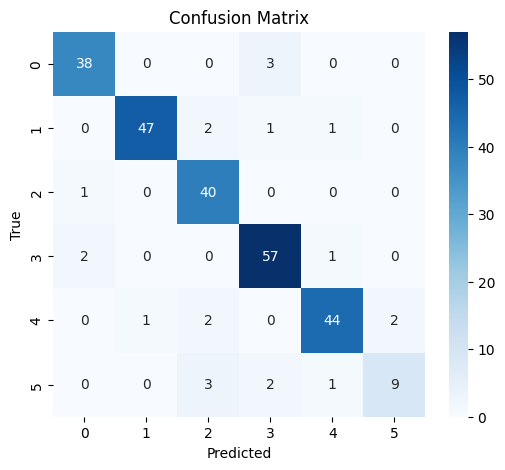

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Part II: Training on multiple datasets

In [19]:
# Download latest version
path2 = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")

print("Path to dataset files:", path2)

Using Colab cache for faster access to the 'garbage-dataset-classification' dataset.
Path to dataset files: /kaggle/input/garbage-dataset-classification


In [20]:
print(os.listdir(path2))

['Garbage_Dataset_Classification']


In [21]:
base_path2 = os.path.join(path2, "Garbage_Dataset_Classification","images")
subfolders = [f for f in os.listdir(base_path2) if os.path.isdir(os.path.join(base_path2, f))]
print(subfolders)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


In [22]:
output_dir2 = "/content/Split2"
splitfolders.ratio(base_path2, output=output_dir2, seed=1337, ratio=(.8, .1, .1))

Copying files: 13901 files [00:51, 267.91 files/s]


In [23]:
train_dir_2 = os.path.join(output_dir, "train")
val_dir_2 = os.path.join(output_dir, "val")
test_dir_2  = os.path.join(output_dir, "test")

In [24]:
CFG = {
    "dataset_root": "/content/Split2",   # change per dataset
    "img_size": (224, 224),                  # EfficientNetB0 likes 224; B3 likes 300; set once
    "batch_size": 32,
    "seed": 42,
    "backbone": "efficientnetb0",            # "efficientnetb0"|"efficientnetb3"|"mobilenetv3large"
    "use_mixed_precision": True
}

train_ds, val_ds, test_ds = make_splits(CFG["dataset_root"])
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES)

Found 11120 files belonging to 6 classes.
Found 1388 files belonging to 6 classes.
Found 1393 files belonging to 6 classes.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [25]:
AUTOTUNE = tf.data.AUTOTUNE

aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.05),
])

# Use the matching preprocess for your backbone
if CFG["backbone"].startswith("efficientnet"):
    from tensorflow.keras.applications.efficientnet import preprocess_input
elif CFG["backbone"].startswith("mobilenetv3"):
    from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
else:
    preprocess_input = lambda x: x

def prep(ds, training=False):
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    return ds.cache().prefetch(AUTOTUNE)

train_ds = prep(train_ds, training=True)
val_ds   = prep(val_ds,   training=False)
test_ds  = prep(test_ds,  training=False) if test_ds is not None else None

In [26]:
@tf.keras.utils.register_keras_serializable()
class ChannelAttention(L.Layer):
    def __init__(self, filters, reduction=16, **kwargs):
        # Accept **kwargs so Keras can pass name, dtype, etc.
        super().__init__(**kwargs)
        self.filters = int(filters)
        self.reduction = int(reduction)
        # Dense layers created in build()

    def build(self, input_shape):
        hidden = max(1, self.filters // self.reduction)
        self.fc1 = L.Dense(hidden, activation="relu", name=self.name + "_mlp_1")
        self.fc2 = L.Dense(self.filters, name=self.name + "_mlp_2")
        super().build(input_shape)

    def call(self, x):
        # x: [B,H,W,C]
        avg = tf.reduce_mean(x, axis=[1, 2])      # [B, C]
        max_ = tf.reduce_max(x, axis=[1, 2])      # [B, C]
        avg_out = self.fc2(self.fc1(avg))
        max_out = self.fc2(self.fc1(max_))
        scale = tf.nn.sigmoid(avg_out + max_out)  # [B, C]
        scale = tf.reshape(scale, [-1, 1, 1, self.filters])
        return x * scale

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"filters": self.filters, "reduction": self.reduction})
        return cfg


@tf.keras.utils.register_keras_serializable()
class SpatialAttention(L.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = int(kernel_size)
        # conv created in build()

    def build(self, input_shape):
        # create conv in build so it's named under this layer and built with proper input_shape
        self.conv = L.Conv2D(filters=1,
                             kernel_size=self.kernel_size,
                             padding="same",
                             use_bias=False,
                             name=self.name + "_conv")
        super().build(input_shape)

    def call(self, x):
        # x: [B,H,W,C]
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)  # [B,H,W,1]
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True) # [B,H,W,1]
        concat = tf.concat([max_pool, avg_pool], axis=-1)    # [B,H,W,2]
        attn = tf.nn.sigmoid(self.conv(concat))              # [B,H,W,1]
        return x * attn

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"kernel_size": self.kernel_size})
        return cfg


@tf.keras.utils.register_keras_serializable()
class CBAM(L.Layer):
    def __init__(self, filters, reduction=16, spatial_kernel=7, **kwargs):
        super().__init__(**kwargs)
        self.filters = int(filters)
        self.reduction = int(reduction)
        self.spatial_kernel = int(spatial_kernel)
        # create child layers in build()
        # Accepts name via kwargs now.

    def build(self, input_shape):
        # build CA and SA with desirable names (they will get names derived from this layer's name)
        self.ca = ChannelAttention(self.filters, reduction=self.reduction, name=self.name + "_CA")
        self.sa = SpatialAttention(kernel_size=self.spatial_kernel, name=self.name + "_SA")
        # call build on sublayers by letting them be created above and Keras will build them when first used
        super().build(input_shape)

    def call(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

    def get_config(self):
        cfg = super().get_config()
        cfg.update({"filters": self.filters, "reduction": self.reduction, "spatial_kernel": self.spatial_kernel})
        return cfg


if CFG.get("use_mixed_precision"):
    tf.keras.mixed_precision.set_global_policy("mixed_float16")


IMG_SHAPE = CFG["img_size"] + (3,)

def get_backbone(name):
    name = name.lower()
    if name == "efficientnetb0":
        return tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)
    if name == "efficientnetb3":
        return tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)
    if name == "mobilenetv3large":
        return tf.keras.applications.MobileNetV3Large(include_top=False, weights="imagenet", input_shape=IMG_SHAPE)
    raise ValueError("Unknown backbone")

base = get_backbone(CFG["backbone"])
base.trainable = False

inp = L.Input(shape=IMG_SHAPE)
features = base(inp, training=False)

channels = int(features.shape[-1])
features = CBAM(channels, name="cbam_final")(features)


x = L.GlobalAveragePooling2D()(features)
x = L.Dropout(0.3)(x)

if NUM_CLASSES == 2:
    out = L.Dense(1, activation="sigmoid", dtype="float32")(x)
    loss = tf.keras.losses.BinaryCrossentropy()
    model_metrics = [
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.AUC(name="pr_auc", curve="PR")
    ]
else:
    out = L.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    model_metrics = ["accuracy"]

model = Model(inp, out)
model.compile(optimizer=Adam(1e-3), loss=loss, metrics=model_metrics)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_final (CBAM)               │ (None, 7, 7, 1280)     │       206,258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,263,515 (16.26 MB)

 Trainable params: 213,944 (835.72 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [27]:
EPOCHS = CFG.get("epochs", 10)     # fallback in case not defined
steps_per_epoch = CFG.get("steps_per_epoch", None)
val_steps = CFG.get("val_steps", None)


callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "Garbage_Classifier_Ver5.keras",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        patience=10,
        factor=0.5,
        min_lr=1e-6
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1
)

print("Training complete!")

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 288s 724ms/step - accuracy: 0.6934 - loss: 0.9457 - val_accuracy: 0.8718 - val_loss: 0.3632 - learning_rate: 0.0010
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8761 - loss: 0.3697 - val_accuracy: 0.8991 - val_loss: 0.2969 - learning_rate: 0.0010
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9107 - loss: 0.2736 - val_accuracy: 0.9063 - val_loss: 0.2645 - learning_rate: 0.0010
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9335 - loss: 0.2035 - val_accuracy: 0.9121 - val_loss: 0.2553 - learning_rate: 0.0010
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9508 - loss: 0.1582 - val_accuracy: 0.9171 - val_loss: 0.2367 - learning_rate: 0.0010
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9584 - loss: 0.1305 - val_accuracy: 0.9222 - val_loss: 0.2238 - learning_rate: 0.0010
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9666 - loss:

In [42]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9521 - loss: 0.1455


In [38]:
y_true = []
y_pred = []
y_score = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())
    y_score.extend(preds)

y_score = np.array(y_score)

print("Done predicting!")

Done predicting!


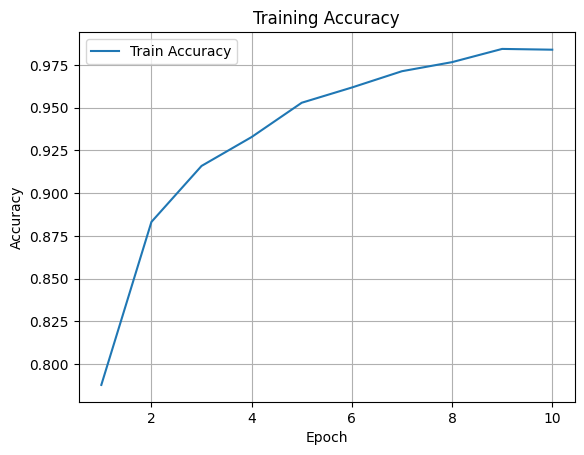

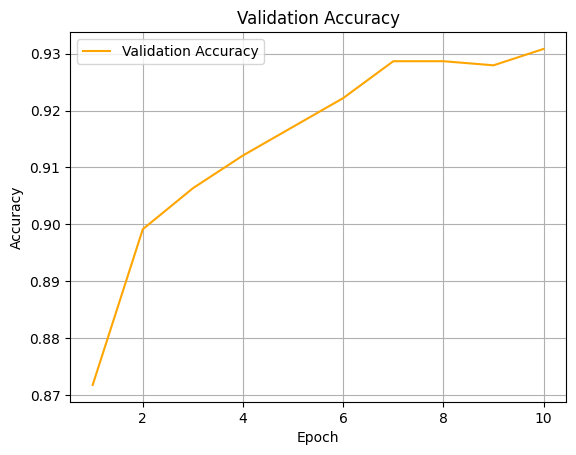

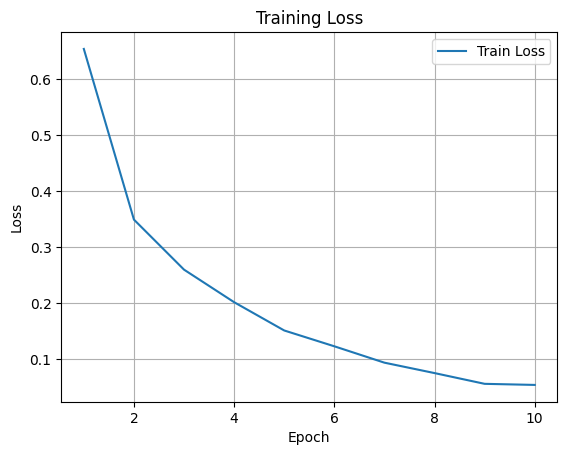

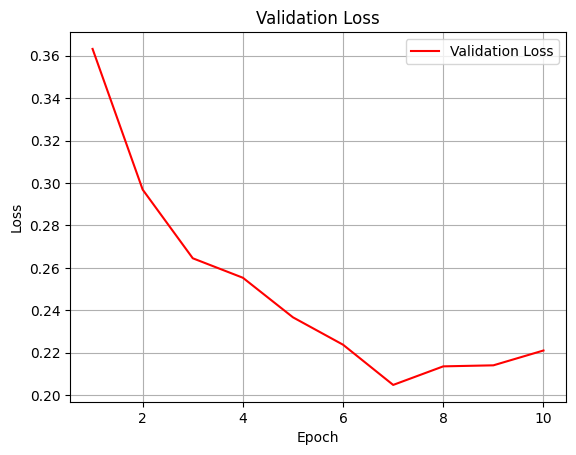

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import os

h = history.history
epochs = range(1, len(h['loss']) + 1)

os.makedirs('figures', exist_ok=True)


plt.figure()
plt.plot(epochs, h.get('accuracy', h.get('acc')), label='Train Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('figures/train_accuracy.png', bbox_inches='tight', dpi=200)
plt.show()


plt.figure()
plt.plot(epochs, h['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)
plt.legend()
plt.savefig('figures/val_accuracy.png', bbox_inches='tight', dpi=200)
plt.show()


plt.figure()
plt.plot(epochs, h['loss'], label='Train Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()
plt.savefig('figures/train_loss.png', bbox_inches='tight', dpi=200)
plt.show()


plt.figure()
plt.plot(epochs, h['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Validation Loss')
plt.grid(True)
plt.legend()
plt.savefig('figures/val_loss.png', bbox_inches='tight', dpi=200)
plt.show()

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np


report_dict = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_df = pd.DataFrame(report_dict).T
report_df.to_csv('figures/classification_report.csv', index=True)


print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

   cardboard       0.94      0.95      0.94       222
       glass       0.94      0.95      0.95       250
       metal       0.90      0.94      0.92       209
       paper       0.93      0.96      0.94       232
     plastic       0.92      0.90      0.91       230
       trash       0.98      0.91      0.95       250

    accuracy                           0.94      1393
   macro avg       0.94      0.94      0.94      1393
weighted avg       0.94      0.94      0.94      1393



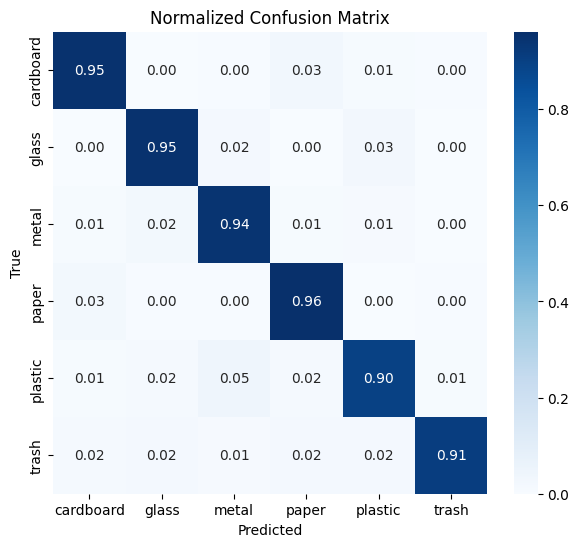

In [40]:
import seaborn as sns
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Normalized Confusion Matrix')
plt.savefig('figures/confusion_matrix.png', bbox_inches='tight', dpi=200)
plt.show()

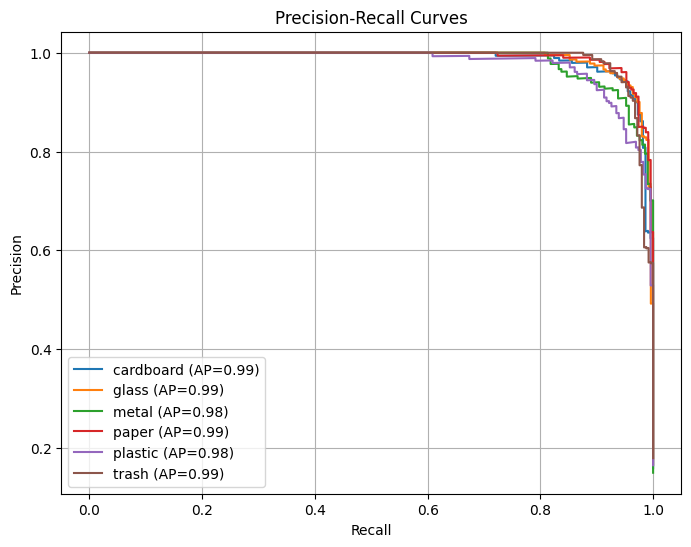

In [41]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

n_classes = NUM_CLASSES

y_true_bin = tf.keras.utils.to_categorical(y_true, num_classes=n_classes)

plt.figure(figsize=(8,6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:,i], y_score[:,i])
    ap = average_precision_score(y_true_bin[:,i], y_score[:,i])
    plt.plot(recall, precision, label=f'{CLASS_NAMES[i]} (AP={ap:.2f})')

plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curves'); plt.legend(loc='lower left'); plt.grid(True)
plt.savefig('figures/pr_curves.png', bbox_inches='tight', dpi=200)
plt.show()

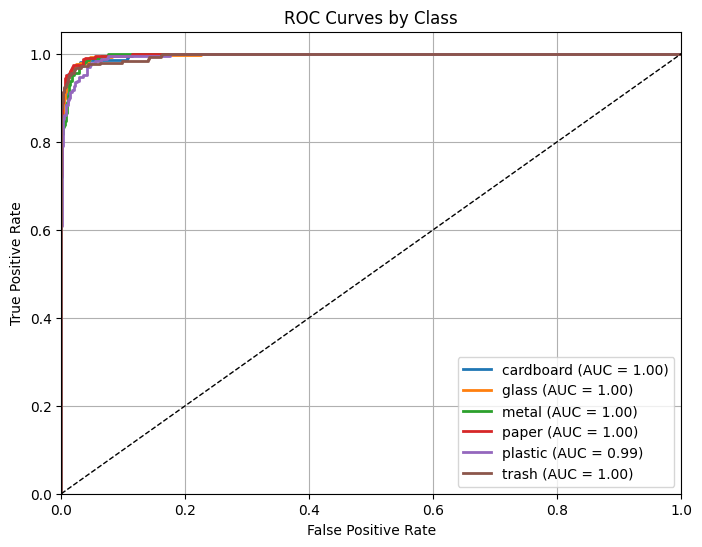

In [44]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_score[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{CLASS_NAMES[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class'); plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('figures/roc_curves.png', bbox_inches='tight', dpi=200)
plt.show()